# Data Collection and Preparation

## 1. Introduction

### 1.1. Project Background
Named Entity Recognition (NER) is a fundamental task in natural language processing that involves identifying and classifying entities such as names of people, organisations, places, or domain-specific concepts within unstructured text. While general-purpose NER models have shown strong performance on benchmark datasets such as CoNLL-2003, their effectiveness decreases when applied to specialised scientific domains. One such domain is environmental science, where named entities often include rare species, chemical compounds, geographical locations, ecological processes, and other scientific terminology not well represented in mainstream corpora.

The application of NER in environmental science has several use cases. These include extracting structured metadata from research papers, supporting environmental knowledge bases, improving search tools for scientific datasets, and automating the indexing of documents in large-scale data repositories. However, the lack of labelled corpora in this domain limits the development of high-quality NER systems.

This notebook is the first part of a broader pipeline developed to create a domain-specific NER dataset for environmental science. It focuses on collecting, cleaning, and segmenting unlabelled raw text from multiple sources, including research data catalogues, scientific abstracts, and environmental news articles. This forms the foundational input for later stages such as vocabulary generation, weak supervision, annotation, and model training. Each subsequent phase is handled in separate notebooks that build on the outputs from this one.

### 1.2. Challenges of NER in Environmental Domain
The task of recognising named entities in environmental science presents several unique challenges that distinguish it from more commonly studied domains such as finance or news media.

First, there is a significant lack of annotated data. Unlike biomedical NLP, which benefits from large labelled corpora like GENIA or BC5CDR, the environmental domain has no established NER datasets of comparable scale or quality. This makes supervised training difficult and requires domain-specific data collection and annotation from scratch.

Second, environmental text contains a high proportion of domain-specific and often rare terminology. These include Latin taxonomic names, technical habitat descriptors, pollutants, and process-related terms that are unlikely to appear in generic training data. Many of these terms are long, nested, or ambiguous in structure, making entity boundary detection more difficult.

Third, the structure and writing style of source material varies widely. Environmental content may come from formal research articles, semi-structured metadata catalogues, government reports, or plain-language news pieces. These sources differ in sentence complexity, formatting, and vocabulary, which presents challenges for both sentence segmentation and entity recognition.

Lastly, named entity categories in this domain often overlap or require fine-grained distinctions. For example, a species name may also refer to a habitat or a threat classification. Similarly, physical quantities and measurements often co-occur with entity mentions, complicating span detection.

These challenges underline the need for a domain-adapted pipeline that begins with high-quality, representative data collection and preprocessing.

### 1.3. Objectives
This notebook focuses on preparing unlabelled environmental text for use in a domain-specific NER pipeline. The main objectives are:

* To gather raw text data from three representative sources: the UK Centre for Ecology & Hydrology (UKCEH) Data Catalogue, PubMed abstracts relevant to environmental science, and an environment-tagged news corpus from Kaggle.
* To clean the text by removing unwanted characters, correcting encoding issues, and flattening inconsistent formatting, particularly in scientific abstracts and metadata descriptions.
* To perform sentence segmentation using a spaCy-based NLP pipeline, standardising the structure of the dataset across sources.
* To carry out quality checks on the segmented sentences, including length distributions, random samples, and validation of data integrity.

These steps ensure that the resulting text is well-formed and ready for the generation of entity vocabularies and annotation tasks in the next stage of the pipeline.

## 2. Data Collection Overview
To support the training of a domain-specific Named Entity Recognition (NER) model, raw text was collected from three environmentally focused sources. Each source offers a distinct combination of writing style, vocabulary, and domain specificity. This diversity is intended to improve the model’s ability to generalise across formal scientific publications, institutional metadata, and public-facing texts.

* **UKCEH Catalogue**

    Structured metadata and attached documents describing environmental datasets. These include dataset abstracts, keywords, and supporting files such as PDF and DOCX documents. The content reflects formal terminology used by researchers, environmental agencies, and academic institutions.
* **PubMed Abstracts**

    Peer-reviewed abstracts retrieved from the biomedical literature database PubMed, using environmentally relevant search terms. These abstracts focus on topics such as taxonomy, ecosystems, pollution, and climate processes, and contain highly technical scientific language.
* **Environmental News Articles**

    Articles selected from a Kaggle dataset of news stories. Texts were filtered to include only articles tagged with environmental themes. These texts reflect public discourse, policy discussions, and environmental reporting, and use more accessible language than scientific literature.


| Source Name              | Content Type                 | Format(s)           | Notes                                               |
|--------------------------|------------------------------|---------------------|-----------------------------------------------------|
| UKCEH Catalogue          | Dataset descriptions + docs  | `.txt` (from PDF/DOCX) | Metadata and supporting documents scraped from web |
| PubMed Abstracts         | Scientific abstracts          | `.txt`              | Retrieved using Entrez API with topic-specific terms |
| Kaggle News Dataset      | News articles on environment | `.csv` > `.txt`     | Filtered for 'environment' tag                      |


In [2]:
from pathlib import Path

# Set up base directory for raw data
BASE_DIR = Path("..") / "data" / "raw_data"
BASE_DIR.mkdir(parents=True, exist_ok=True)

### 2.1. UKCEH Data Collection
The UK Centre for Ecology & Hydrology (UKCEH) provides an online catalogue of environmental datasets covering domains such as land use, biodiversity, and water quality. Each dataset entry includes structured metadata such as the title, description, keywords, and geographic scope. Many entries also provide access to ZIP archives containing supplementary documents, including project reports, technical notes, and data collection methodologies.

This source was selected for its structured and domain-specific content. The text includes formal references to research organisations, projects, geographic areas, and scientific processes. This makes it a suitable source of environmental language for named entity recognition.

A custom web scraper was developed to extract both metadata and attached documents. The scraper collected metadata fields from each catalogue page and downloaded ZIP archives where available. Documents in formats such as PDF, DOCX, and TXT were unpacked and converted to plain text using appropriate parsers.

To ensure ethical data collection, the scraper respected the site’s robots.txt file, included a custom user-agent header, and applied random delays between requests. All text was collected for academic research purposes and stored in a structured directory format for reproducibility.

#### Setup and Imports
This section defines the required dependencies, base paths, and constants used throughout the UKCEH scraping pipeline. External libraries are used for HTML parsing, document processing, and browser automation. Output files are stored in a structured directory layout under the project base path.

In [3]:
import os
import time
import tempfile
import zipfile
import re
import unicodedata
import contextlib
import io

# HTTP and HTML parsing
import requests
from bs4 import BeautifulSoup

# Browser Automation
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# Document Processing
import pandas as pd
from docx import Document
from pdfminer.high_level import extract_text as extract_pdf_text
import filetype
import fitz
import pytesseract
from PIL import Image

# Target directory for UKCEH data
UKCEH_DIR = BASE_DIR / "ukceh"
UKCEH_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FILE = UKCEH_DIR / "ukceh_data.txt"

# Base URL for CEH catalogue
BASE_URL = "https://catalogue.ceh.ac.uk"

#### Retrieving Dataset Links
The UKCEH catalogue uses JavaScript to dynamically load dataset entries on each page. To access these, Selenium is used to render the full page content before parsing. This function takes a page number as input and returns a list of full dataset URLs listed on that page. If no results are found, it returns an empty list.

In [3]:
def get_links_from_page(page_num):
    """Return dataset links from a single UKCEH catalogue page"""
    url = f"{BASE_URL}/?page={page_num}"
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.quit()

    results_list = soup.find("div", class_="results__list")
    if not results_list:
        return []

    dataset_links = [
        BASE_URL + a['href']
        for a in results_list.find_all("a", href=True)
        if a['href'].startswith("/documents/")
    ]
    return dataset_links

#### Extracting Dataset Metadata
Each dataset page contains a title, a short descriptive summary, and often a link to a ZIP archive of supporting documents. This function retrieves those three elements from a given dataset URL. The content is parsed directly from the page HTML using BeautifulSoup. If no document link is available, the function returns `None` for the download field.

In [4]:
def get_dataset_info(dataset_url):
    """Extract the title, description, and download link from a dataset page"""
    response = requests.get(dataset_url)
    soup = BeautifulSoup(response.text, "html.parser")

    title = soup.find("h1").get_text(strip=True)
    
    desc_div = soup.find("div", class_="description-text")
    description = desc_div.get_text(strip=True) if desc_div else ""

    supporting_tag = soup.find("a", class_="btn btn-access")
    supporting_link = supporting_tag['href'] if supporting_tag else None

    return title, description, supporting_link

#### Extracting Text from Individual Files
Supporting documents appear in multiple formats, primarily PDF, DOCX, and plain text. This function attempts to extract usable plain text from each file. 

For PDF files, a two-step fallback method is used. The function first attempts direct text extraction using `pdfminer`. If this returns no content, the file is likely a scanned image rather than a text-based PDF. In such cases, optical character recognition (OCR) is applied using `pytesseract` in combination with `PyMuPDF`. OCR works by identifying characters from images of text, which makes it suitable for recovering content from scanned documents that cannot be parsed normally.

DOCX files are processed using `python-docx`, and plain text files are read directly. Files that cannot be parsed or yield no usable text are skipped.

In [5]:
def read_file_text(file_path):
    """Extract plain text from PDF, DOCX, or TXT files using format-specific parsing"""
    try:
        kind = filetype.guess(file_path)
        ext = kind.extension if kind else os.path.splitext(file_path)[-1].lower()

        if ext == "pdf":
            # Try direct PDF text extraction
            with contextlib.redirect_stderr(io.StringIO()):
                text = extract_pdf_text(file_path).replace("\n", " ").strip()
            if text:
                return text

            # Fallback to OCR if direct extraction fails
            text_parts = []
            doc = fitz.open(file_path)
            for page in doc:
                pix = page.get_pixmap(dpi=300)
                img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
                ocr_text = pytesseract.image_to_string(img).strip()
                if ocr_text:
                    text_parts.append(ocr_text.replace("\n", " "))
            return " ".join(text_parts).strip()

        elif ext == "docx":
            doc = Document(file_path)
            return " ".join(p.text for p in doc.paragraphs).strip()

        elif ext == "txt":
            with open(file_path, encoding="utf-8", errors="ignore") as f:
                return f.read().replace("\n", " ").strip()

        else:
            return ""

    except Exception as e:
        return ""

#### Downloading and Reading ZIP Archives
Each dataset may include a link to a ZIP archive containing one or more supporting documents. These ZIP files are not browsable individually on the UKCEH catalogue, so downloading and extracting them is necessary to access their contents.

The below function downloads the archive to a temporary directory, unpacks its contents, and applies the document parsing logic defined earlier. Valid documents are processed to extract text, while files with unsupported formats such as `.json`, `.html`, or `.rtf` are skipped.

Text extracted from all readable files is combined into a single string. This content is later combined with the dataset title and description for output. Files that cannot be downloaded or parsed are handled gracefully without interrupting the process.

In [6]:
def extract_text_from_zip(zip_url, dataset_id):
    """Download and extract text from a ZIP archive of supporting documents"""
    try:
        response = requests.get(zip_url)
        if not response.ok:
            
            return ""

        with tempfile.TemporaryDirectory() as tmpdir:
            zip_path = os.path.join(tmpdir, f"{dataset_id}.zip")
            with open(zip_path, "wb") as f:
                f.write(response.content)

            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(tmpdir)

            text_chunks = []
            for root, _, files in os.walk(tmpdir):
                for name in files:
                    file_path = os.path.join(root, name)
                    try:
                        text = read_file_text(file_path)
                        if text:
                            text_chunks.append(text)
                    except Exception as e:
                        print(f"Failed to read file {name}: {e}")

            return " ".join(text_chunks).strip()
    except Exception as e:
        print(f"Exception: {e}")
        return ""

#### Writing Output to File
Each dataset entry is written to a single line in a raw text file. This includes the title, the summary description, and any extracted text content from supporting documents. No text cleaning or normalisation is applied at this stage. The full content is preserved as originally retrieved for use in later preprocessing.

In [7]:
def write_to_file(title, url, description, extracted_text, output_file):
    """Write a dataset entry to the output file as a single line of raw text"""
    line = f"{title} | {description} | {extracted_text}".strip()
    
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(line + "\n")

#### Scraping All Pages
This loop iterates through all 114 pages of the UKCEH catalogue and processes each dataset entry. For every result, it extracts the metadata, downloads and parses any supporting documents, and writes the combined text to a single output file.

The number of pages is fixed based on the structure of the public catalogue. Scraping each page ensures complete coverage of the available datasets.

In [8]:
for page in range(1, 115):
    print(f"Scraping page {page}")
    urls = get_links_from_page(page)

    if not urls:
        print(f"No results on page {page}")
        break

    for url in urls:
        try:
            title, desc, zip_link = get_dataset_info(url)
            dataset_id = url.split("/")[-1]
            extracted = ""

            if zip_link:
                extracted = extract_text_from_zip(zip_link, dataset_id)

            write_to_file(title, url, desc, extracted, OUTPUT_FILE)
        except Exception as e:
            print(f"Error: {e}")
            continue

Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10
Scraping page 11
Scraping page 12
Scraping page 13
Scraping page 14
Scraping page 15
Scraping page 16
Scraping page 17
Scraping page 18
Scraping page 19
Scraping page 20
Scraping page 21
Exception: Response ended prematurely
Scraping page 22
Scraping page 23
Scraping page 24
Scraping page 25
Scraping page 26
Scraping page 27
Scraping page 28
Scraping page 29
Scraping page 30
Scraping page 31
Scraping page 32
Scraping page 33
Scraping page 34
Scraping page 35
Scraping page 36
Scraping page 37
Scraping page 38
Scraping page 39
Scraping page 40
Scraping page 41
Scraping page 42
Scraping page 43
Scraping page 44
Scraping page 45
Scraping page 46
Scraping page 47
Scraping page 48
Scraping page 49
Scraping page 50
Scraping page 51
Scraping page 52
Scraping page 53
Scraping page 54
Scraping page 55
Scraping page 56
Scraping page 57
Sc

In [9]:
with open(OUTPUT_FILE, "r", encoding="utf-8") as f:
    print(f"Total datasets collected: {len(f.readlines())}")

Total datasets collected: 6458


A total of 6458 datasets were collected from the UKCEH catalogue. Each entry includes the dataset title, summary description, and any extractable text from supporting documents. This output forms the full raw text corpus for this source.


### 2.2. Environment News Article (Kaggle)
The second data source consists of news articles related to environmental topics, originally published by `The Guardian` and made available as a publicly shared Kaggle dataset. The dataset includes metadata along with the article title, introduction, and full body text. It is manually downloaded as a CSV file from the following source:

https://www.kaggle.com/datasets/beridzeg45/guardian-environment-related-news

This source was included to increase linguistic diversity in the corpus. Compared to scientific abstracts and metadata, news articles are written in a more accessible and informal style. This variation helps ensure that the collected text represents a wider range of language used in environmental communication.

Each row in the dataset was processed to join the title, introduction, and article body into a single text string. Rows with missing fields were excluded. The final output was saved as plain text, with one article per line.

In [10]:
ENV_NEWS_DIR = BASE_DIR / "environment_news"
ENV_NEWS_DIR.mkdir(parents=True, exist_ok=True)

csv_path = ENV_NEWS_DIR / "env_news_data.csv"
output_path = ENV_NEWS_DIR / "env_news_data.txt"

In [11]:
# Load CSV
df = pd.read_csv(csv_path, engine="python", on_bad_lines="skip")

# Drop rows with missing fields and join text columns
combined_lines = df[["Title", "Intro Text", "Article Text"]].dropna().astype(str).apply(
    lambda row: " | ".join([
        row["Title"].replace("\n", " ").replace("\r", " ").strip(),
        row["Intro Text"].replace("\n", " ").replace("\r", " ").strip(),
        row["Article Text"].replace("\n", " ").replace("\r", " ").strip()
    ]),
    axis=1
)

output_path = csv_path.parent / "data.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for line in combined_lines:
        f.write(line + "\n")

In [13]:
with open(output_path, "r", encoding="utf-8") as f:
    print(f"Total articles: {len(f.readlines())}")

Total articles: 28669


A total of 28,669 articles were processed from the Kaggle dataset and saved as plain text. This represents a substantial volume of unlabelled content for NER, drawn from a source that reflects how environmental topics are discussed in public communication and media reporting.

### 2.3. PubMed Abstracts
PubMed is a biomedical and life sciences literature database maintained by the U.S. National Library of Medicine. Although its focus is primarily health-related, it includes a substantial volume of research relevant to environmental science, such as studies on ecosystems, biodiversity, pollution, and habitat change.

To supplement the dataset with high-quality scientific language, abstracts were retrieved manually using PubMed’s web interface. Search terms were selected to reflect major environmental themes, including biodiversity, climate, pollutants, species, and habitat. For each query, up to 10,000 abstracts were exported in `.txt` format.

This approach was chosen over API based access to avoid rate limits and technical constraints associated with bulk downloading. Manual collection through the user interface ensured full access to content while complying with usage terms. Each abstract was saved as plain text without titles or metadata.

Upon manual inspection, it was confirmed that abstracts are separated by blank lines. The below function was used to merge broken lines within each abstract and accurately count the total number of entries across all files.

In [13]:
PIBMED_DIR = BASE_DIR / "pubmed"
abstract_files = sorted(PIBMED_DIR.glob("abstract-*.txt"))

def merge_pubmed_lines(input_path):
    """Merge broken abstract lines using blank lines as separators"""
    with open(input_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f]

    abstracts = []
    current = []
    for line in lines:
        if line:
            current.append(line)
        else:
            if current:
                abstracts.append(" ".join(current))
                current = []
    if current:
        abstracts.append(" ".join(current))
    return abstracts


total_abstracts = sum(len(merge_pubmed_lines(file)) for file in abstract_files)
print(f"Total abstracts collected: {total_abstracts}")

Total abstracts collected: 441812


A total of 441,812 abstracts were collected from PubMed and included in the dataset as plain text.

## 3. Preprocessing Raw Text
The raw text collected from UKCEH documents, PubMed abstracts, and Kaggle news articles contains several inconsistencies that require light preprocessing before sentence segmentation and annotation. These include formatting artefacts, broken lines, bullet symbols, and occasional encoding issues.

Text from the UKCEH source requires particular attention. Many of the supporting documents were extracted from scanned PDFs using OCR, which introduces broken encodings, repeated spacing, and stray Unicode characters. Light preprocessing is needed to make this content structurally consistent with the other sources.

Preprocessing is applied conservatively to preserve the original surface forms of entities. No transformations are performed that would affect capitalisation, token structure, or grammar.

The following types of issues were observed during manual inspection:

- Bullet characters (e.g. `•`, `▪`, `►`) at the start of lines
- Section labels or figure references (e.g. `Table 1`, `Appendix A`)
- Broken Unicode symbols or non-standard characters
- Line breaks splitting logical sentences across multiple lines (especially in PubMed)

To handle these, a small number of cleaning steps are applied to normalise spacing and remove obvious noise. However, more aggressive text preprocessing techniques are avoided, as they are unsuitable for named entity recognition. For example:

- **Lowercasing** is avoided because many entity types (e.g. species names, locations, chemical compounds) rely on capitalisation to be correctly identified.
- **Stopword removal** is not applied since some entities contain common stopwords (e.g. *River of Life*, *Department of the Environment*).
- **Stemming or lemmatisation** may distort entity boundaries and forms, reducing the reliability of span-based annotation.

The goal of this phase is to clean structural noise while preserving the original surface form of all text content.

Below are examples of problematic lines from the raw data:


### 3.1. Inspecting Example from UKCEH
The example below shows a raw line from the UKCEH data containing issues commonly found in the source, such as repeated spacing, OCR artefacts, long unstructured blocks, and irrelevant supplier or copyright text. These problems highlight the need for light cleaning before further processing.

In [14]:
example_lines = []

with open(UKCEH_DIR / "ukceh_data.txt", encoding="utf-8") as f:
    for line in f:
        # Check if line contains any non-ASCII characters
        if any(ord(char) > 127 for char in line):
            example_lines.append(("Non-ASCII character", line.strip()))
        if len(example_lines) == 3:
            break

for label, content in example_lines:
    print(f"{label}: {content}")

Non-ASCII character: Woodlands survey tree diameter data 1971-2001 | The dataset consists of diameter at breast height (DBH) measurements taken from trees and shrubs recorded in plots in 103 woodland sites surveyed across Great Britain in 1971 and again over the growing seasons of 2000, 2002 and 2003 (referred to as '2001 survey'), using exactly the same field methods. Data were collected under projects managed by The Nature Conservancy (in 1971) and the Centre for Ecology & Hydrology (in 2001).Publication date: 2013-12-10 | PA nde  NATIONAL WOODLANDS CLASSIFICATION 1971,  HANDBOOK OF FIELD METHODS  by  M. W. Shaw and R. G. H. Bunce  y  Woodlands Research Section - Merlewood ; Revised Fdition 9 July 1971 Asking permission  Locating a plot  —  —_ ne  BAC  Wi  2  Z AB  AY General  Access and Permission to Survey Sites  Starting the Survey  Location of the Sampling Points  Order of Recording Data  Recording of Plot Data  ( ( ( (  aap  ) Ground flora  ) Trees, saplings and shrubs  ) Plot d

### 3.2. Cleaning and Merging Functions
The following functions apply structural cleaning to the raw text collected from each source. This includes normalising Unicode symbols, removing unwanted characters, and filtering out lines that contain little or no meaningful content.

The cleaning logic is consistent across all three sources, with a small exception for PubMed, which requires line merging before cleaning. As shown earlier, PubMed abstracts are separated by blank lines, and often split across multiple lines due to export formatting. A merging step is applied before cleaning in that case.

No aggressive preprocessing is applied. The functions are designed to preserve surface forms while removing obvious formatting issues and inconsistencies.

In [15]:
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [16]:
def clean_line(line):
    line = line.strip()
    if not line:
        return None

    line = unicodedata.normalize("NFKD", line)  # remove weird Unicode ligatures
    line = re.sub(r"[•▪●‣–—·]", " ", line)  # bullet points
    line = re.sub(r"\.{3,}", "...", line)  # collapse dot chains
    line = re.sub(r"https?://\S+", "", line)  # remove URLs
    line = re.sub(r"[\x00-\x1F\x7F-\x9F]", "", line)  # remove control chars
    line = re.sub(r"\s{2,}", " ", line)  # extra spaces

    if len(line.split()) < 3:  # junk (like Table 1, Appendix etc)
        return None

    return line

In [17]:
def clean_file(input_path, output_path, is_pubmed=False):
    if is_pubmed:
        raw_lines = merge_pubmed_lines(input_path)
    else:
        with open(input_path, "r", encoding="utf-8") as infile:
            raw_lines = infile.readlines()

    cleaned_lines = []
    for line in raw_lines:
        cleaned = clean_line(line)
        if cleaned:
            cleaned_lines.append(cleaned)

    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, "w", encoding="utf-8") as outfile:
        for line in cleaned_lines:
            outfile.write(line + "\n")

    print(f"Saved cleaned file: {output_path.name}")

In [18]:
for source in ["ukceh", "environment_news", "pubmed"]:
    raw_dir = BASE_DIR / source
    clean_dir = PROCESSED_DIR / source
    clean_dir.mkdir(parents=True, exist_ok=True)

    for txt_file in raw_dir.glob("*.txt"):
        is_pubmed = (source == "pubmed")
        clean_file(txt_file, clean_dir / txt_file.name, is_pubmed=is_pubmed)


Saved cleaned file: ukceh_data.txt (2653 lines)
Saved cleaned file: data.txt (28669 lines)
Saved cleaned file: abstract-habitat.txt (136427 lines)
Saved cleaned file: abstract-env_process.txt (66957 lines)
Saved cleaned file: abstract-environment.txt (66376 lines)
Saved cleaned file: abstract-taxonomy.txt (45741 lines)
Saved cleaned file: abstract-pollutants.txt (61937 lines)
Saved cleaned file: abstract-measurement.txt (58694 lines)


### 3.3. Reviewing Cleaned Output
The examples printed below show how the raw UKCEH lines have been cleaned using the functions defined above. Issues such as repeated spacing, OCR symbols, and unwanted boilerplate have been removed. The text remains intact and readable, with no changes to structure or meaning.

These lines confirm that light preprocessing is enough to make the text consistent without losing useful information.

In [20]:
for i, (_, raw_text) in enumerate(example_lines, 1):
    cleaned = clean_line(raw_text)
    print(cleaned)

Woodlands survey tree diameter data 1971-2001 | The dataset consists of diameter at breast height (DBH) measurements taken from trees and shrubs recorded in plots in 103 woodland sites surveyed across Great Britain in 1971 and again over the growing seasons of 2000, 2002 and 2003 (referred to as '2001 survey'), using exactly the same field methods. Data were collected under projects managed by The Nature Conservancy (in 1971) and the Centre for Ecology & Hydrology (in 2001).Publication date: 2013-12-10 | PA nde NATIONAL WOODLANDS CLASSIFICATION 1971, HANDBOOK OF FIELD METHODS by M. W. Shaw and R. G. H. Bunce y Woodlands Research Section - Merlewood ; Revised Fdition 9 July 1971 Asking permission Locating a plot _ ne BAC Wi 2 Z AB AY General Access and Permission to Survey Sites Starting the Survey Location of the Sampling Points Order of Recording Data Recording of Plot Data ( ( ( ( aap ) Ground flora ) Trees, saplings and shrubs ) Plot description and habitats ) Soil data Completion o

## 4. Sentence Segmentation
After cleaning, the text remains in multi-sentence blocks that must be split into individual sentences for named entity recognition. Most NER models operate at the sentence level to preserve entity boundaries and reduce mislabelling across sentence breaks. Similarly, annotation tools and evaluation scripts typically expect input to follow a one-sentence-per-line format.

Sentence segmentation is therefore a necessary step between raw text preparation and later tasks such as annotation and model training.

The segmentation is performed using `spaCy`, a widely used NLP library that combines rule-based token patterns with statistical models to identify sentence boundaries. spaCy uses built-in language-specific rules to detect sentence breaks based on punctuation, orthographic features (e.g. capitalisation), and dependency parse structure. These heuristics work well for grammatically formal text such as scientific abstracts and technical reports, which make up the majority of the input.

No custom segmentation rules are added, as spaCy’s default model handles the structure of environmental science text with sufficient accuracy. Each cleaned text file is processed line by line. Paragraphs and document sections are passed through the sentence parser, and the resulting sentences are written out in plain text format, one per line. This structure ensures compatibility with common annotation formats while preserving the original sentence boundaries as accurately as possible.

### 4.1. Segmenting Sentences with spaCy 

In [23]:
import spacy
from pathlib import Path

# Load spaCy model and increase max length to handle large documents
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000

INPUT_DIR = Path("../data/processed")
OUTPUT_DIR = Path("../data/segmented_text")

def segment_sentences_streaming(input_path, output_path):
    """Split each block of text into sentences using spaCy and write one sentence per line"""
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(input_path, "r", encoding="utf-8") as infile, open(output_path, "w", encoding="utf-8") as outfile:
        for block in infile:
            block = block.strip()
            if not block:
                continue

            # Apply sentence segmentation
            doc = nlp(block)
            for sent in doc.sents:
                sentence = sent.text.strip()
                if sentence:
                    outfile.write(sentence + "\n")

    print(f"Finished: {output_path.name}")

for source in ["ukceh", "environment_news", "pubmed"]:
    input_folder = INPUT_DIR / source
    output_folder = OUTPUT_DIR / source
    output_folder.mkdir(parents=True, exist_ok=True)

    for file_path in input_folder.glob("*.txt"):
        output_path = output_folder / file_path.name
        segment_sentences_streaming(file_path, output_path)

Finished: ukceh_data.txt
Finished: data.txt
Finished: abstract-habitat.txt
Finished: abstract-env_process.txt
Finished: abstract-environment.txt
Finished: abstract-taxonomy.txt
Finished: abstract-pollutants.txt
Finished: abstract-measurement.txt


### 4.2. Total Sentence Count
After segmentation, each sentence is written on a separate line in the `segmented_text` directory. To confirm the overall size of the dataset, the total number of sentences across all sources is calculated below.

In [24]:
total_sentences = 0

for source in ["ukceh", "environment_news", "pubmed"]:
    source_dir = OUTPUT_DIR / source
    for file_path in source_dir.glob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            total_sentences += sum(1 for _ in f)

print(f"Total sentences: {total_sentences}")

Total sentences: 2910834


The combined total is approximately **2,910,834 sentences**, which provides a substantial base for named entity recognition. Not all of these will contain useful information: sentences without any matched entities will be discarded automatically during the annotation phase. This allows for broad coverage during collection while maintaining precision at training time.

### 4.3. Sentence Counts per Source
To better understand the distribution of sentences, the number of segmented sentences is calculated separately for each data source. This breakdown reflects the scale and variability of content drawn from scientific literature, environmental datasets, and public news.

In [25]:
source_counts = {}

for source in ["ukceh", "environment_news", "pubmed"]:
    count = 0
    source_dir = OUTPUT_DIR / source
    for file_path in source_dir.glob("*.txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            count += sum(1 for _ in f)
    source_counts[source] = count

for source, count in source_counts.items():
    print(f"{source}: {count} sentences")

ukceh: 457676 sentences
environment_news: 982393 sentences
pubmed: 1470765 sentences


The number of sentences per source is as follows:

- **ukceh_data**: 457,676 
- **environment_news**: 982,393  
- **pubmed abstracts**: 1,470,765  

PubMed contributes the largest volume of text, reflecting the scale of downloaded abstracts across multiple environmental topics. News articles make up the second-largest share, offering broader language coverage and less formal structure. Although UKCEH accounts for a smaller portion, it provides high-value scientific text with consistent terminology. Together, these sources contribute a balanced mix of sentence styles and content types, which is beneficial for training a generalisable NER model.

## 5. Sentence Quality Checks and Statistics
Basic quality checks are applied to the segmented sentence data before annotation begins. These help confirm that the output is structurally sound and suitable for named entity recognition.

Sentence length is one way to assess this. Short or unusually long sentences are often the result of export artefacts, formatting issues, or inconsistent writing styles. Identifying these cases early makes it easier to decide which sentences are likely to be useful for annotation and which may need to be filtered out.

### 5.1. Sentence Length Statistics
To understand the overall structure and complexity of the collected sentences, we calculate the average sentence length in two forms:

- **Tokens**: Using spaCy's tokenizer (e.g. number of words and symbols)
- **Characters**: Total number of characters per sentence

This gives a useful overview of sentence complexity, which helps assess model readiness. For example, longer sentences might span multiple clauses, increasing the likelihood of nested or multiple entities, while shorter sentences might favour simpler structure but higher ambiguity.

In [33]:
from tqdm import tqdm
import spacy
from pathlib import Path

OUTPUT_DIR = Path("../data/segmented_text")

In [34]:
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000

OUTPUT_DIR = Path("../data/segmented_text")

def get_avg_sentence_lengths(folder):
    total_chars = 0
    total_tokens = 0
    total_sentences = 0

    txt_files = list(folder.glob("*.txt"))

    for file_path in txt_files:
        with open(file_path, "r", encoding="utf-8") as f:
            lines = [line.strip() for line in f if line.strip()]
            for line in tqdm(lines, desc=f"Processing {file_path.name}", leave=False):
                total_chars += len(line)
                total_tokens += len(nlp.make_doc(line))  # fast token count
                total_sentences += 1

    avg_chars = total_chars / total_sentences if total_sentences else 0
    avg_tokens = total_tokens / total_sentences if total_sentences else 0

    return avg_tokens, avg_chars, total_sentences

for source in ["ukceh", "environment_news", "pubmed"]:
    folder = OUTPUT_DIR / source
    avg_tokens, avg_chars, count = get_avg_sentence_lengths(folder)
    print(f"\n{source}:")
    print(f"Total sentences: {count:,}")
    print(f"Avg tokens per sentence: {avg_tokens:.2f}")
    print(f"Avg characters per sentence: {avg_chars:.2f}")



ukceh:
Total sentences: 457,676
Avg tokens per sentence: 22.84
Avg characters per sentence: 115.41



environment_news:
Total sentences: 982,393
Avg tokens per sentence: 27.21
Avg characters per sentence: 142.88



pubmed:
Total sentences: 1,470,765
Avg tokens per sentence: 18.17
Avg characters per sentence: 101.76


From the analysis, environment news articles had the longest sentences on average, followed by UKCEH, with PubMed abstracts having the shortest.

| Source               | Avg Tokens | Avg Characters |
|----------------------|------------|----------------|
| UKCEH                | 22.84      | 115.41         |
| Environment News     | 27.21      | 142.88         |
| PubMed Abstracts     | 18.17      | 101.76         |

These averages fall within a reasonable range for NER tasks. The variation reflects differences in writing style and structure between sources: journalistic articles favour longer, descriptive phrasing, while scientific abstracts tend to be more concise. UKCEH content shows moderate sentence lengths, reflecting structured but sometimes technical text.


### 5.2. Sentence Length Extremes
To assess structural variation across the dataset, this section reports the minimum, maximum, and average sentence lengths (in characters) for each source. These values help indicate whether some sources contain overly long or short constructions that may impact annotation quality or model input limits.

While longer sentences may contain useful context, they can also introduce ambiguity or span multiple entities. Very short sentences, on the other hand, may lack meaningful information. Understanding these patterns supports later filtering decisions or model configuration choices.

In [35]:
all_stats = {}

def get_detailed_sentence_stats(folder):
    char_lengths = []
    token_lengths = []

    txt_files = list(folder.glob("*.txt"))
    total_lines = 0

    for file_path in txt_files:
        with open(file_path, "r", encoding="utf-8") as f:
            total_lines += sum(1 for line in f if line.strip())

    with tqdm(total=total_lines, desc=f"Scanning {folder.name}", leave=False) as pbar:
        for file_path in txt_files:
            with open(file_path, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    char_lengths.append(len(line))
                    token_lengths.append(len(nlp.make_doc(line)))
                    pbar.update(1)

    return {
        "total": len(char_lengths),
        "char_min": min(char_lengths),
        "char_max": max(char_lengths),
        "char_avg": sum(char_lengths) / len(char_lengths),
        "token_min": min(token_lengths),
        "token_max": max(token_lengths),
        "token_avg": sum(token_lengths) / len(token_lengths),
        "token_lengths": token_lengths,
    }

for source in ["ukceh", "environment_news", "pubmed"]:
    folder = OUTPUT_DIR / source
    stats = get_detailed_sentence_stats(folder)
    all_stats[source] = stats
    print(f"\n{source}:")
    print(f"Total sentences: {stats['total']:,}")
    print(f"Min char length: {stats['char_min']}, Max: {stats['char_max']}, Avg: {stats['char_avg']:.2f}")
    print(f"Min token count: {stats['token_min']}, Max: {stats['token_max']}, Avg: {stats['token_avg']:.2f}")



ukceh:
Total sentences: 457,676
Min char length: 1, Max: 19760, Avg: 115.41
Min token count: 1, Max: 10589, Avg: 22.84



environment_news:
Total sentences: 982,393
Min char length: 1, Max: 3233, Avg: 142.88
Min token count: 1, Max: 482, Avg: 27.21



pubmed:
Total sentences: 1,470,765
Min char length: 1, Max: 7553, Avg: 101.76
Min token count: 1, Max: 1809, Avg: 18.17


All sources contain sentences as short as one token, and outliers as long as several thousand tokens.

| Source               | Min Tokens | Max Tokens | Min Chars | Max Chars |
|----------------------|------------|------------|-----------|-----------|
| UKCEH                | 1          | 10,589     | 1         | 19,760    |
| Environment News     | 1          | 482        | 1         | 3,233     |
| PubMed Abstracts     | 1          | 1,809      | 1         | 7,553     |

Extremely long sentences are typically caused by formatting errors, OCR noise, or mis-segmented paragraphs. Short sentences of one token are likely artefacts or low-quality content. These outliers will be filtered in the next step to improve annotation and model consistency.

### 5.3. Sentence Length Histogram
A histogram of sentence lengths gives a visual overview of sentence distribution across the dataset. This helps confirm whether most examples fall within a typical range (e.g. 10–30 tokens), or whether certain sources skew toward unusually short or verbose constructions.

This type of plot is often used as a sanity check during dataset preparation. It also helps inform future decisions about sequence length limits or truncation strategies if the data is later used to train transformer-based models.

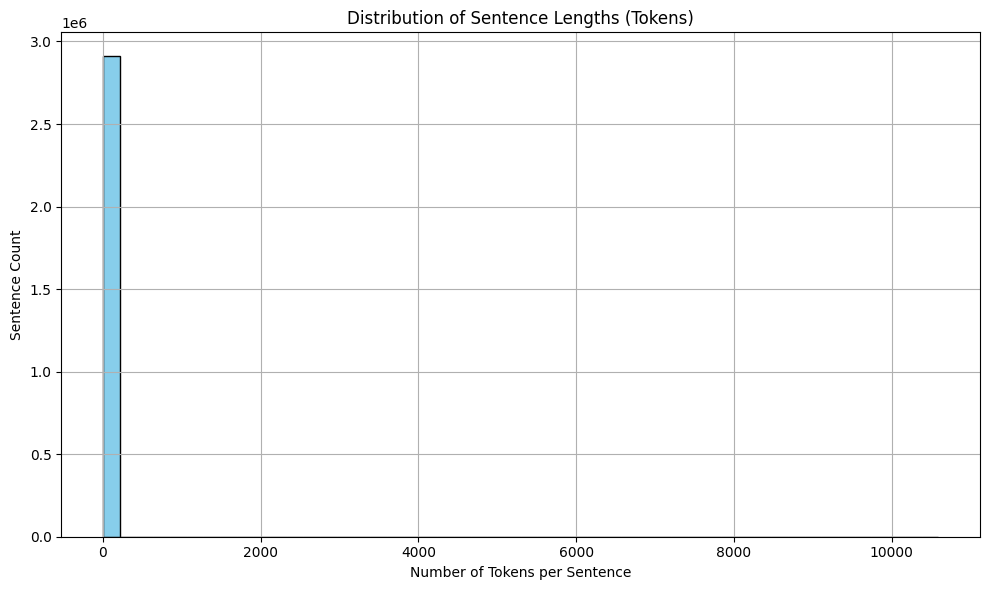

In [36]:
import matplotlib.pyplot as plt

token_lengths = []
for stats in all_stats.values():
    token_lengths.extend(stats["token_lengths"])

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Sentence Lengths (Tokens)")
plt.xlabel("Number of Tokens per Sentence")
plt.ylabel("Sentence Count")
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram shows a sharp left-skewed distribution, with the vast majority of sentences concentrated under 50 tokens. However, a small number of extreme outliers inflate the x-axis range.

This distortion is consistent with earlier statistics showing sentences as long as 10,000 tokens. These outliers will be filtered in the next step to improve clarity and reduce noise.

### 5.4. Sentence Length Filtering
To reduce the impact of extreme outliers, sentences shorter than 5 tokens or longer than 200 tokens are removed from the dataset. Very short sentences often contain little or no useful information, while very long ones are more likely to contain formatting noise.

This filtering step improves the overall quality and consistency of the text. It also simplifies annotation by focusing on sentence lengths that are more likely to be meaningful and well-structured.

In [43]:
token_thresholds = (5, 200)

def filter_and_save_sentences(input_dir, min_tokens=5, max_tokens=200):
    """Filter sentences by token length and overwrite segmented_text files"""
    all_token_lengths = {}
    for source in ["ukceh", "environment_news", "pubmed"]:
        source_stats = {
            "before_count": 0,
            "after_count": 0,
            "total_tokens": 0,
            "total_chars": 0,
        }
        token_lengths = []

        folder = input_dir / source
        txt_file = next(folder.glob("*.txt"))  # assumes one .txt per folder

        with open(txt_file, "r", encoding="utf-8") as f:
            lines = [line.strip() for line in f if line.strip()]
            source_stats["before_count"] = len(lines)

        lines_kept = []
        for line in tqdm(lines, desc=f"Filtering {source}", leave=False):
            doc = nlp.make_doc(line)
            token_count = len(doc)
            if min_tokens <= token_count <= max_tokens:
                lines_kept.append(line)
                source_stats["after_count"] += 1
                source_stats["total_tokens"] += token_count
                source_stats["total_chars"] += len(line)
                token_lengths.append(token_count)

        with open(txt_file, "w", encoding="utf-8") as f:
            for line in lines_kept:
                f.write(line + "\n")

        all_token_lengths[source] = token_lengths

        if source_stats["after_count"]:
            avg_tokens = source_stats["total_tokens"] / source_stats["after_count"]
            avg_chars = source_stats["total_chars"] / source_stats["after_count"]
        else:
            avg_tokens = avg_chars = 0

        print(f"\n{source} summary:")
        print(f"Original sentences: {source_stats['before_count']:,}")
        print(f"Filtered sentences: {source_stats['after_count']:,}")
        print(f"Avg tokens: {avg_tokens:.2f}")
        print(f"Avg characters: {avg_chars:.2f}")

    return all_token_lengths

In [44]:
_ = filter_and_save_sentences(OUTPUT_DIR, *token_thresholds)


ukceh summary:
Original sentences: 457,676
Filtered sentences: 397,910
Avg tokens: 25.17
Avg characters: 128.43



environment_news summary:
Original sentences: 982,393
Filtered sentences: 950,259
Avg tokens: 28.04
Avg characters: 147.36



pubmed summary:
Original sentences: 462,159
Filtered sentences: 391,880
Avg tokens: 21.23
Avg characters: 121.02


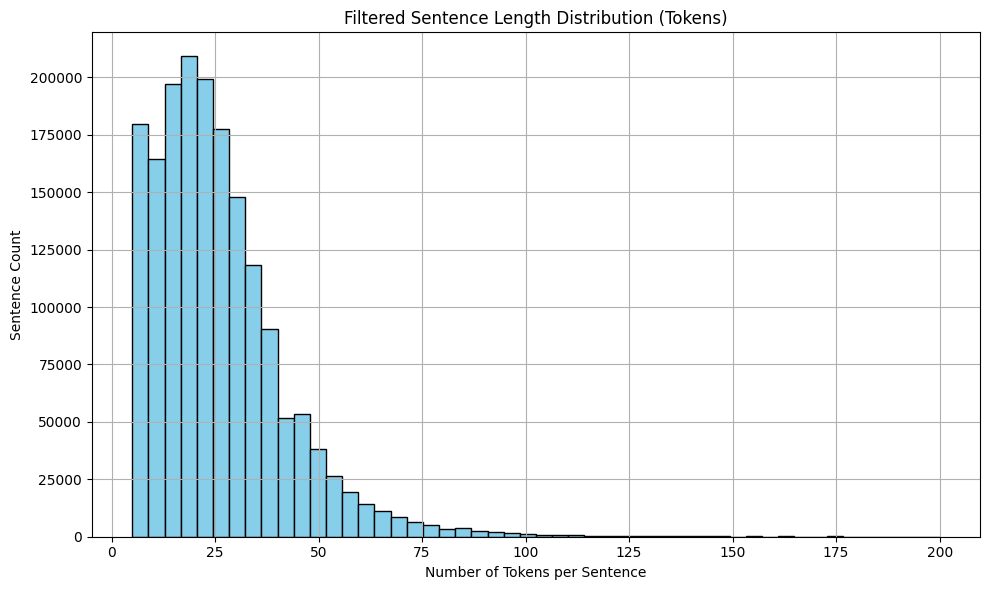

In [50]:
filtered_token_lengths = (
    _["ukceh"] +
    _["environment_news"] +
    _["pubmed"]
)

plt.figure(figsize=(10, 6))
plt.hist(filtered_token_lengths, bins=50, color="skyblue", edgecolor="black")
plt.title("Filtered Sentence Length Distribution (Tokens)")
plt.xlabel("Number of Tokens per Sentence")
plt.ylabel("Sentence Count")
plt.grid(True)
plt.tight_layout()
plt.show()


After filtering, sentence counts were reduced across all sources. UKCEH dropped from 457,676 to 397,910 sentences. Environment news decreased from 982,393 to 950,259, while PubMed abstracts were reduced from 462,159 to 391,880. The average sentence length after filtering remained within a reasonable range: 25.17 tokens and 128.43 characters for UKCEH, 28.04 tokens and 147.36 characters for environment news, and 21.23 tokens and 121.02 characters for PubMed.

These changes indicate that most sentences fell within the expected length boundaries, with only a minority removed due to structural issues or formatting noise. The filtered dataset now contains more consistent and meaningful sentence units, suitable for named entity recognition. The histogram of sentence lengths confirms this, showing a clean left-skewed distribution concentrated between 10 and 60 tokens. Very few sentences approach the 200-token upper limit, suggesting the filtering step successfully removed outliers while retaining a representative core of the data.

No further sentence-level filtering is applied beyond this step. Additional outliers, if any, will be handled implicitly during automatic annotation. Sentences with no matched entities will be discarded at that stage. This approach avoids excessive preprocessing and ensures that sentence coverage aligns directly with annotation coverage.

## 6. Final Summary

### 6.1. Summary of Data Processed
This notebook prepares a clean, segmented sentence dataset for use in named entity recognition within the environmental science domain. Text was collected from three distinct sources: UKCEH scientific documents, PubMed environmental abstracts, and a Kaggle dataset of environmental news articles. These sources represent a diverse mix of technical and journalistic writing.

Raw text files were cleaned to remove encoding errors, bullet characters, tables, section headings, and other formatting artefacts. PubMed abstracts were further processed to merge broken lines into coherent text blocks. Sentence segmentation was applied using spaCy and saved as plain `.txt` files for each source.

Basic quality checks were conducted, including sentence length statistics, histograms, and filtering. Sentences under 5 tokens or over 200 tokens were removed to eliminate low-quality or noisy data. Final sentence counts and averages confirmed the consistency of the dataset. The result is a well-structured sentence-level corpus, ready for automated annotation once entity definitions are in place.

### 6.2. Next Steps
The next step is to define and collect vocabulary lists for each named entity category. These categories may include species, habitats, environmental processes, pollutants, and measurements. This vocabulary building will be addressed in a separate notebook `02_vocabulary_building.ipynb` and will form the basis for future annotation.

Once term lists are complete, automatic annotation will be applied using dictionary-based matching. Only sentences that contain at least one matched term will be retained. Annotation quality will be evaluated using coverage statistics and tag distribution summaries. If manual review is introduced later, inter-annotator agreement may also be considered.

This sentence-level dataset and the planned vocabularies will form the foundation for building a domain-specific NER model in environmental science.
